In [1]:
import generate_masterdf as gm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from generate_plots import subject_wise_error_plot, quick_visualization, distribution_plots
from helpers import variance_error_summary
pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 4)

We have 9 subjects so far: ['sub01', 'sub03', 'sub06', 'sub08', 'sub12', 'sub13', 'sub14', 'sub15', 'sub16']

Loading existing dataframe! If this is not desired, delete the current mater_df.csv


In [2]:
df = gm.master_df
df = variance_error_summary(df)
print('Dataframe description')
df.info()

Dataframe description
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10800 entries, 0 to 10799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   subjID                  10800 non-null  int64  
 1   day                     10800 non-null  int64  
 2   tnum                    10800 non-null  int64  
 3   rnum                    10800 non-null  int64  
 4   istms                   10800 non-null  int64  
 5   ispro                   10800 non-null  int64  
 6   instimVF                10800 non-null  int64  
 7   breakfix                10800 non-null  int64  
 8   no_prim_sacc            10800 non-null  int64  
 9   small_sacc              10800 non-null  int64  
 10  large_error             10800 non-null  int64  
 11  rejtrials               10800 non-null  int64  
 12  TarX                    10800 non-null  float64
 13  TarY                    10800 non-null  float64
 14  isaccX          

In [ ]:
df.describe()
df.describe(include=object)

In [3]:
n_rows_original = len(df)
# Filter out entries with 'rejtrials' == 1
df_filtered = df[(df['rejtrials'] != 1)].copy()
df_filtered = df_filtered.dropna()
n_rows_filtered = len(df_filtered)
print(f"Original = {n_rows_original}, after filtering = {n_rows_filtered} trials.")
print()
print('Dataframe description after filtering')
df_filtered.info()

Original = 10800, after filtering = 9755 trials.

Dataframe description after filtering
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9755 entries, 0 to 10798
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   subjID                  9755 non-null   int64  
 1   day                     9755 non-null   int64  
 2   tnum                    9755 non-null   int64  
 3   rnum                    9755 non-null   int64  
 4   istms                   9755 non-null   int64  
 5   ispro                   9755 non-null   int64  
 6   instimVF                9755 non-null   int64  
 7   breakfix                9755 non-null   int64  
 8   no_prim_sacc            9755 non-null   int64  
 9   small_sacc              9755 non-null   int64  
 10  large_error             9755 non-null   int64  
 11  rejtrials               9755 non-null   int64  
 12  TarX                    9755 non-null   float64
 13  TarY

In [ ]:
# Summary across conditions for subjects
table_summary = pd.pivot_table(df, values = 'fsacc_err', index = ['subjID'], columns = ['TMS_condition', 'ispro'], aggfunc = lambda x: np.sum(~pd.isnull(x)))
table_summary

In [ ]:
raw_error_summary = pd.pivot_table(df_filtered, values = ['fsacc_err', 'fsacc_theta_err', 'fsacc_radius_err'], index = ['subjID'], columns = ['TMS_condition', 'ispro'], aggfunc = lambda x: np.nanmean(np.abs(x)))
raw_error_summary

In [ ]:
error_summary = pd.pivot_table(df_filtered, values = ['fsacc_theta_rot_normed', 'fsacc_theta_rot'], index = ['subjID'], columns = ['TMS_condition', 'ispro'], aggfunc = lambda x: np.nanmean(np.abs(x)))
error_summary

In [ ]:
df_filtered.describe()
df_filtered.describe(include=object)

In [ ]:
subjIDs = df_filtered['subjID'].unique()
#df_filtered = df_filtered[df_filtered['instimVF'] == 0 ]
for ii in range(len(subjIDs)):
    plt.figure()
    plt.plot(df_filtered[df_filtered['subjID']==subjIDs[ii]]['TarX'], df_filtered[df_filtered['subjID']==subjIDs[ii]]['TarY'], 'r.', markersize = 2)
    plt.plot(df_filtered[df_filtered['subjID']==subjIDs[ii]]['fsaccX'], df_filtered[df_filtered['subjID']==subjIDs[ii]]['fsaccY'], 'ks', markersize = 2)
    plt.xlim(-25, 25)
    plt.ylim(-20, 20)
    plt.title(str(subjIDs[ii]))

In [ ]:
subjIDs = df_filtered['subjID'].unique()
#df_filtered = df_filtered[(df_filtered['TarTheta'] > -np.pi/2) & (df_filtered['TarTheta'] < np.pi/2) ]
for ii in range(len(subjIDs)):
    plt.figure()
    plt.plot(df_filtered[df_filtered['subjID']==subjIDs[ii]]['TarX_rotated'], df_filtered[df_filtered['subjID']==subjIDs[ii]]['TarY_rotated'], 'ro', markersize = 4)
    plt.plot(df_filtered[df_filtered['subjID']==subjIDs[ii]]['fsaccX_rotated'], df_filtered[df_filtered['subjID']==subjIDs[ii]]['fsaccY_rotated'], 'ks', markersize = 2)
    plt.xlim([0, 25])
    plt.ylim([-20, 20])
    plt.title(str(subjIDs[ii]))

In [ ]:
table_summary_hh = pd.pivot_table(df, values = 'TarTheta_rotated', index = ['subjID'], columns = ['TMS_condition', 'ispro'], aggfunc = lambda x: (np.max(x) - np.min(x)) * (180/np.pi))
table_summary_hh

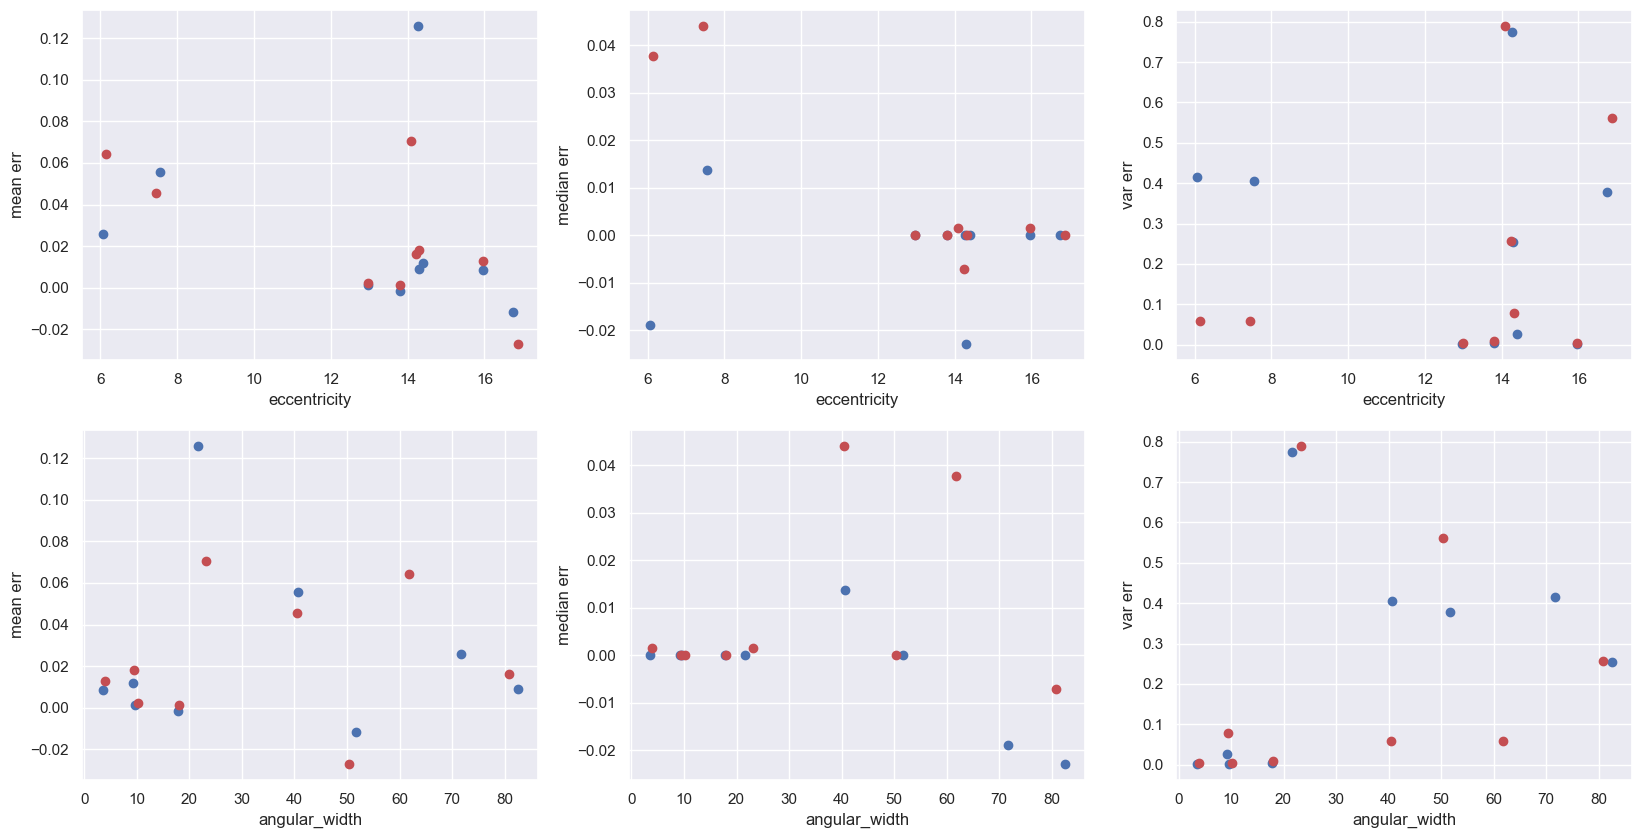

In [26]:
## Check for any existing trend in data due to eccentricity or angular width
subjIDs = df_filtered['subjID'].unique()
angular_width = np.zeros((len(subjIDs), 2) )
eccs = np.zeros((len(subjIDs),2) )
mean_err = np.zeros((len(subjIDs), 2))
median_err = np.zeros((len(subjIDs), 2))
var_err = np.zeros((len(subjIDs), 2))
err_met = 'fsacc_theta_err'
for ii in range(len(subjIDs)):
    this_subj_df_pro = df_filtered[(df_filtered['subjID']==subjIDs[ii]) & (df_filtered['TMS_condition']=='No TMS') & (df_filtered['ispro']==1) ]
    this_subj_df_anti = df_filtered[(df_filtered['subjID']==subjIDs[ii]) & (df_filtered['TMS_condition']=='No TMS') & (df_filtered['ispro']==0)]
    mean_err[ii, 0] = np.nanmean(this_subj_df_pro[err_met])
    median_err[ii, 0] = np.nanmedian(this_subj_df_pro[err_met])
    var_err[ii, 0] = np.nanvar(this_subj_df_pro[err_met])
    mean_err[ii, 1] = np.nanmean(this_subj_df_anti[err_met])
    median_err[ii, 1] = np.nanmedian(this_subj_df_anti[err_met])
    var_err[ii, 1] = np.nanvar(this_subj_df_anti[err_met])
    angular_width[ii, 0] = (this_subj_df_pro['TarTheta_rotated'].max() - this_subj_df_pro['TarTheta_rotated'].min()) * (180/np.pi)
    angular_width[ii, 1] = (this_subj_df_anti['TarTheta_rotated'].max() - this_subj_df_anti['TarTheta_rotated'].min()) * (180/np.pi)
    eccs[ii, 0] = this_subj_df_pro['TarRadius'].mean()
    eccs[ii, 1] = this_subj_df_anti['TarRadius'].mean()

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 10))
axs[0, 0].plot(eccs[:, 0], mean_err[:, 0], 'bo')
axs[0, 0].plot(eccs[:, 1], mean_err[:, 1], 'ro')
axs[0, 0].set_xlabel('eccentricity')
axs[0, 0].set_ylabel('mean err')

axs[0, 1].plot(eccs[:, 0], median_err[:, 0], 'bo')
axs[0, 1].plot(eccs[:, 1], median_err[:, 1], 'ro')
axs[0, 1].set_xlabel('eccentricity')
axs[0, 1].set_ylabel('median err')

axs[0, 2].plot(eccs[:, 0], var_err[:, 0], 'bo')
axs[0, 2].plot(eccs[:, 1], var_err[:, 1], 'ro')
axs[0, 2].set_xlabel('eccentricity')
axs[0, 2].set_ylabel('var err')

axs[1, 0].plot(angular_width[:, 0], mean_err[:, 0], 'bo')
axs[1, 0].plot(angular_width[:, 1], mean_err[:, 1], 'ro')
axs[1, 0].set_xlabel('angular_width')
axs[1, 0].set_ylabel('mean err')

axs[1, 1].plot(angular_width[:, 0], median_err[:, 0], 'bo')
axs[1, 1].plot(angular_width[:, 1], median_err[:, 1], 'ro')
axs[1, 1].set_xlabel('angular_width')
axs[1, 1].set_ylabel('median err')

axs[1, 2].plot(angular_width[:, 0], var_err[:, 0], 'bo')
axs[1, 2].plot(angular_width[:, 1], var_err[:, 1], 'ro')
axs[1, 2].set_xlabel('angular_width')
axs[1, 2].set_ylabel('var err')
plt.show()


/opt/anaconda3/envs/mgs/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


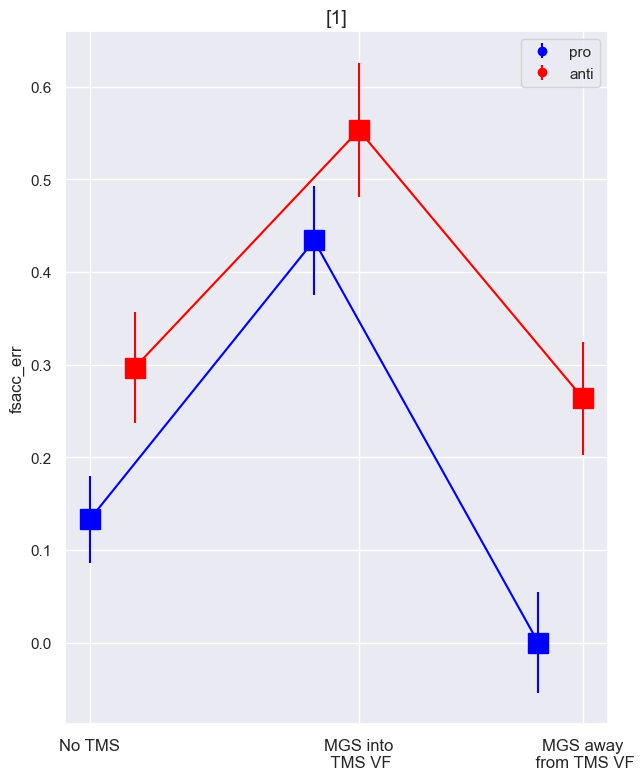

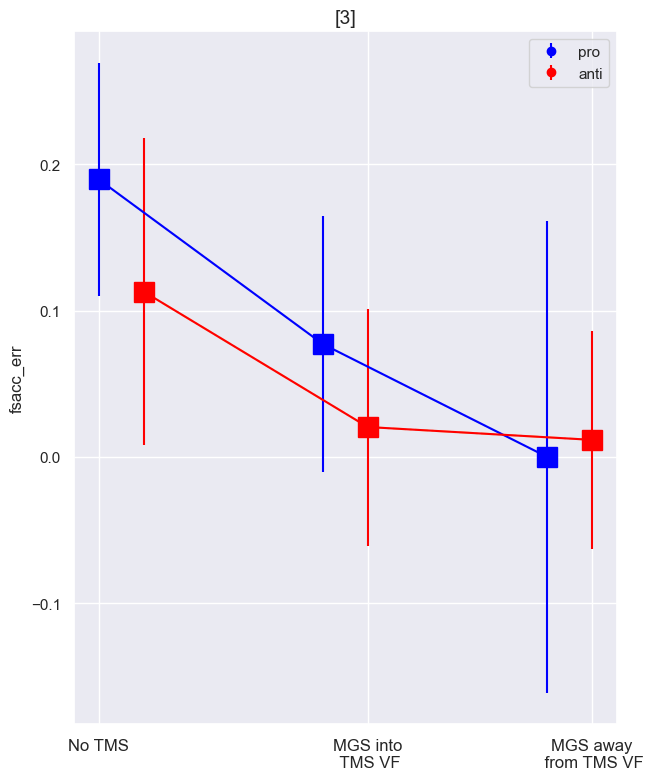

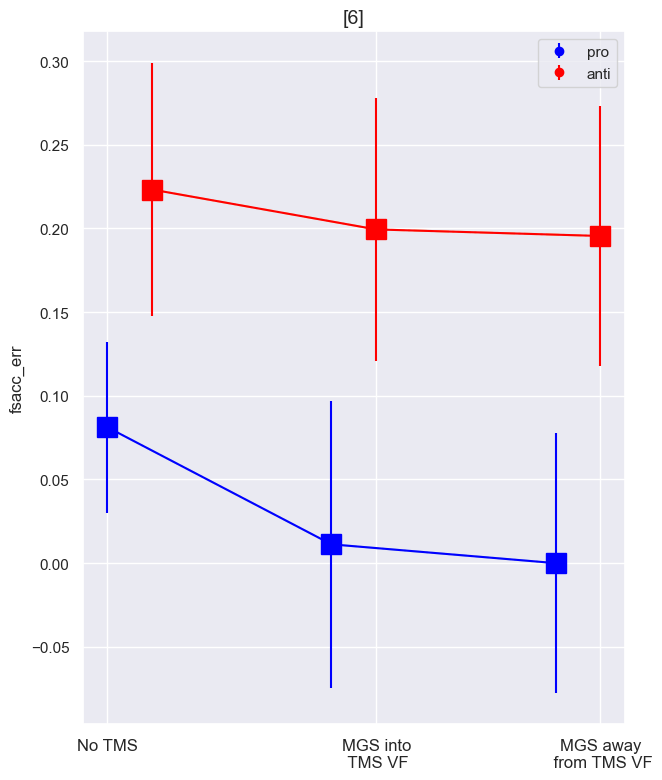

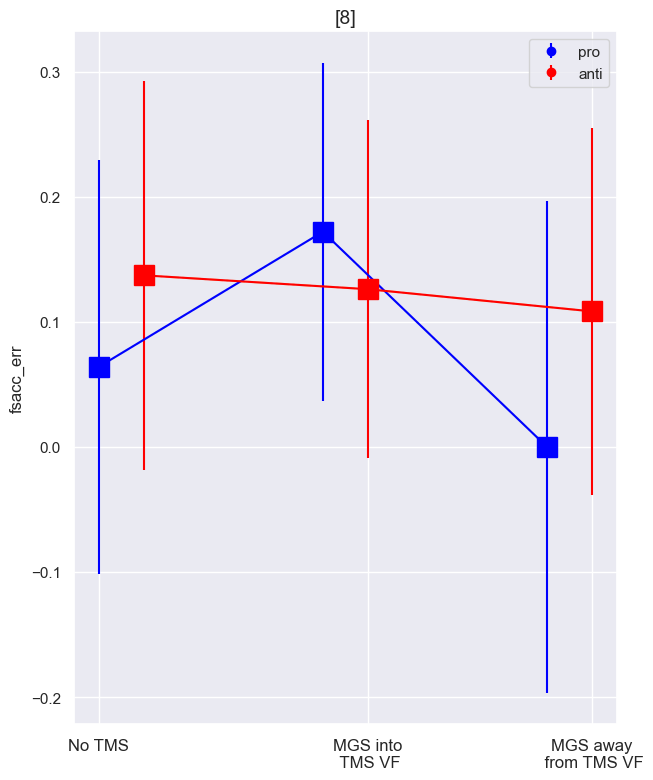

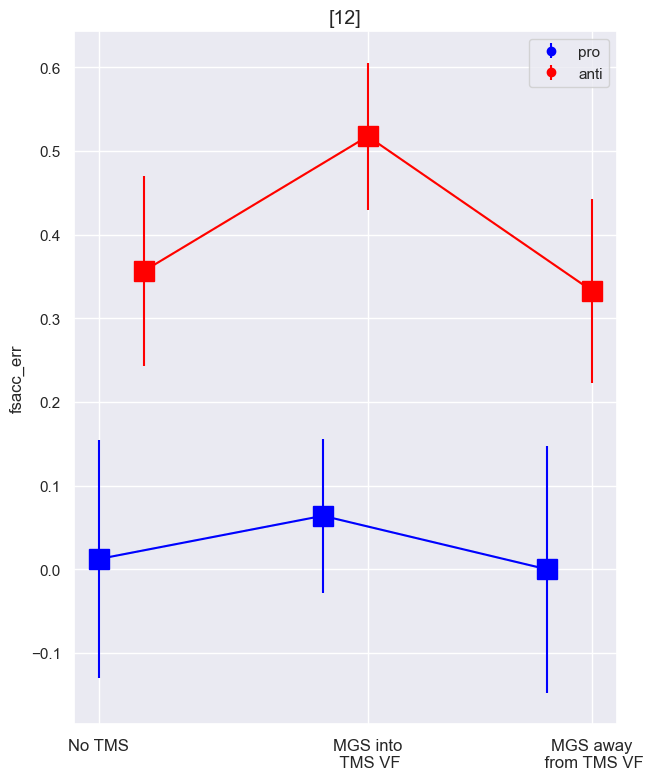

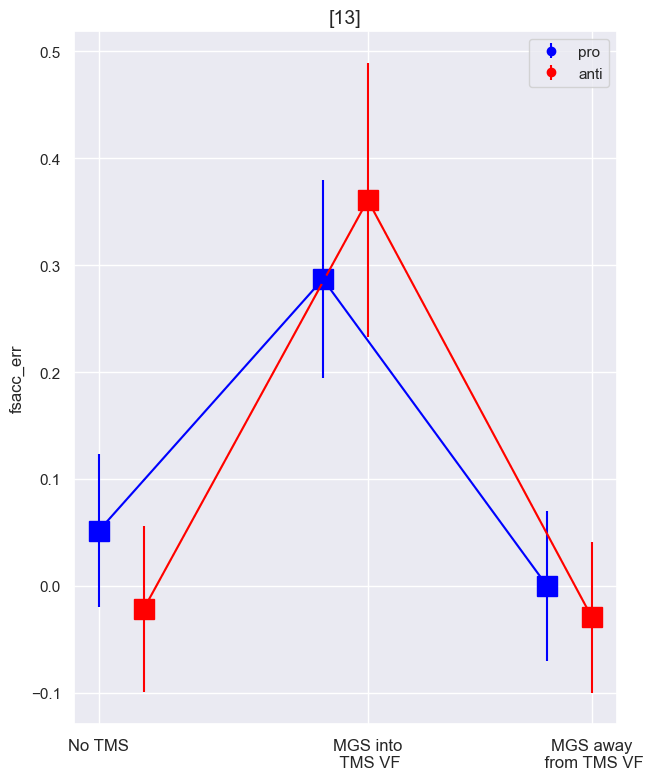

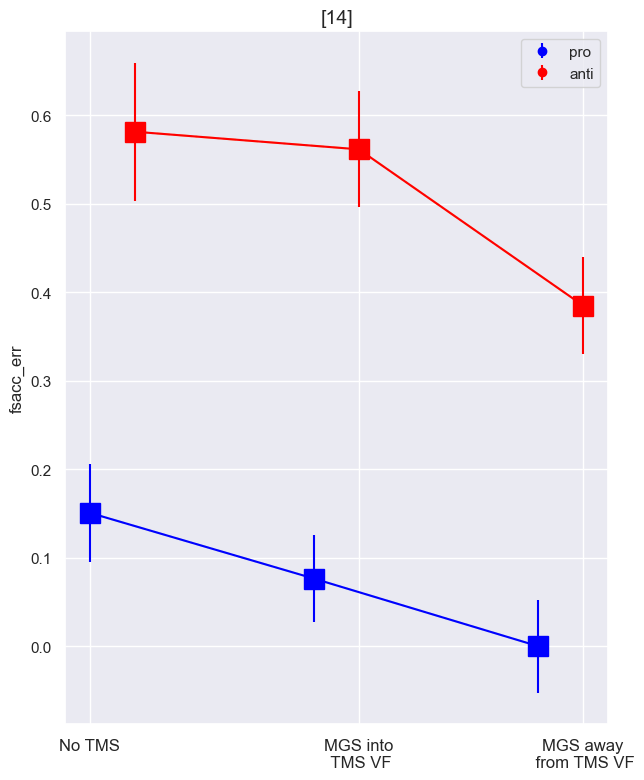

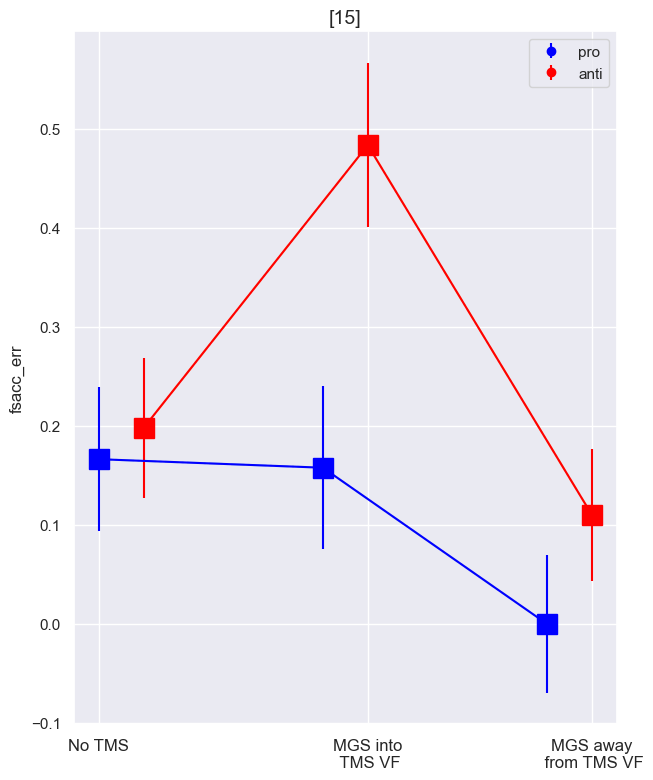

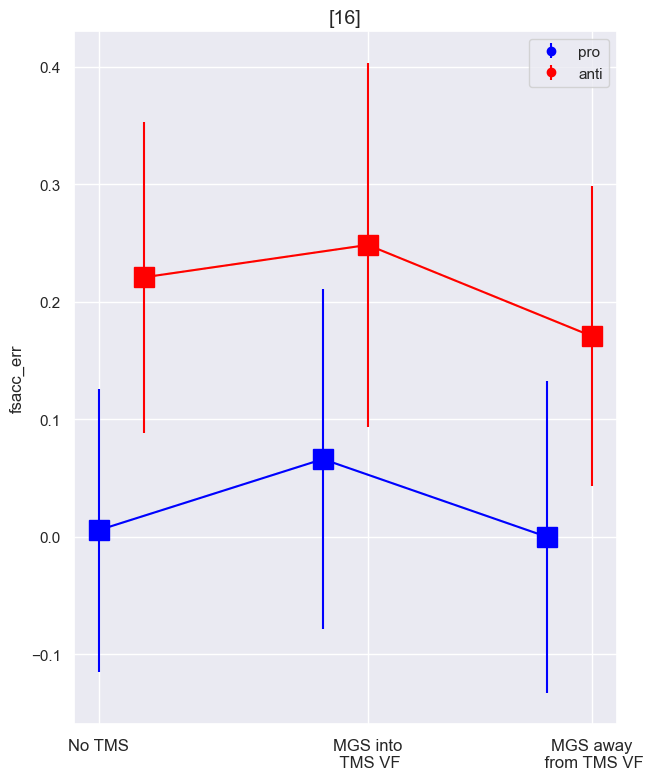

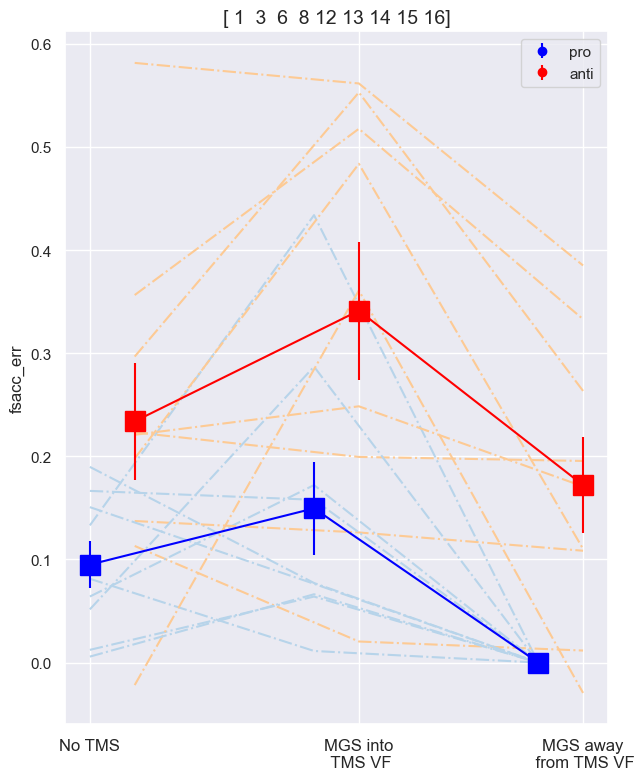

In [4]:
#subject_wise_error_plot(df_filtered, 'fsacc_theta_err')
#subject_wise_error_plot(df_filtered, 'corrected_theta_err')
#subject_wise_error_plot(df_filtered, 'isacc_radius_err')
#subject_wise_error_plot(df_filtered, 'fsacc_radius_err')

#subject_wise_error_plot(df_filtered, 'corrected_radius_err')
subjIDs = df_filtered['subjID'].unique()
#df_filtered['fsacc_theta_err'] = df_filtered['fsacc_theta_err'].abs()
for ii in range(len(subjIDs)):
    subject_wise_error_plot(df_filtered[df_filtered['subjID'] == subjIDs[ii]], 'fsacc_err', True)
    #subject_wise_error_plot(df_filtered[df_filtered['subjID'] == subjIDs[ii]], 'fsacc_err')
#df_filtered['fsacc_theta_err'] = np.abs(df_filtered['fsacc_theta_err'])
subject_wise_error_plot(df_filtered, 'fsacc_err', True)
#subject_wise_error_plot(df_filtered, 'isacc_peakvel')
#subject_wise_error_plot(df_filtered, 'fsacc_peakvel')

In [ ]:
subjIDs = df['subjID'].unique()
max_ax = 25
for ss in range(len(subjIDs)):
    subj_df =  df[df['subjID']==subjIDs[ss]]
    fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 15))
    plt.suptitle(subjIDs[ss])
    axes[0, 0].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[0, 0].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[0, 1].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[0, 1].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    
    axes[1, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[1, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[1, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[1, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    
    axes[2, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[2, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[2, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[2, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    

    axes[0, 0].set_xlim([-max_ax, max_ax])
    axes[0, 0].set_ylim([-max_ax, max_ax])
    axes[0, 1].set_xlim([-max_ax, max_ax])
    axes[0, 1].set_ylim([-max_ax, max_ax])
    axes[1, 0].set_xlim([-max_ax, max_ax])
    axes[1, 0].set_ylim([-max_ax, max_ax])
    axes[1, 1].set_xlim([-max_ax, max_ax])
    axes[1, 1].set_ylim([-max_ax, max_ax])
    axes[2, 0].set_xlim([-max_ax, max_ax])
    axes[2, 0].set_ylim([-max_ax, max_ax])
    axes[2, 1].set_xlim([-max_ax, max_ax])
    axes[2, 1].set_ylim([-max_ax, max_ax])

    axes[0, 0].set_box_aspect(1)
    axes[0, 1].set_box_aspect(1)
    axes[1, 0].set_box_aspect(1)
    axes[1, 1].set_box_aspect(1)
    axes[2, 0].set_box_aspect(1)
    axes[2, 1].set_box_aspect(1)

    axes[0, 0].set_title('No TMS & pro')
    axes[0, 1].set_title('No TMS & anti')
    axes[1, 0].set_title('TMS intoVF & pro')
    axes[1, 1].set_title('TMS intoVF & anti')
    axes[2, 0].set_title('TMS outVF & pro')
    axes[2, 1].set_title('TMS outVF & anti')
    plt.show()
    

In [ ]:
from scipy.stats import circmean
r = np.linspace(8, 12, 1000)
r_sacc = np.linspace(12, 8, 1000)
theta_rang = np.linspace(-np.pi, np.pi, 1000)
theta_sacc = np.linspace(np.pi, -np.pi, 1000)
x = r * np.cos(theta_rang)
y = r * np.sin(theta_rang)
x_sacc = r_sacc * np.cos(theta_sacc)
y_sacc = r_sacc * np.sin(theta_sacc)
raw_error = np.sqrt((x-x_sacc)**2+(y-y_sacc)**2)

mean_target = circmean(theta_rang, high=np.pi, low=-np.pi)
this_angle = -1*mean_target
#radial_error = np.max(r) - r
#radial_error_sacc = np.max(r) - r_sacc
rotation_matrix = np.array([[np.cos(this_angle), -np.sin(this_angle)],
                                    [np.sin(this_angle), np.cos(this_angle)]])

x_temp = x #+ radial_error * np.cos(theta_rang)
y_temp = y #+ radial_error * np.sin(theta_rang)
input_target = np.vstack((x_temp, y_temp))
rotated_target = np.dot(rotation_matrix, input_target)
x_rot = rotated_target[0]
y_rot = rotated_target[1]

x_sacc_temp = x_sacc #+ radial_error_sacc * np.cos(theta_sacc)
y_sacc_temp = y_sacc #+ radial_error_sacc * np.sin(theta_sacc)
input_sacc = np.vstack((x_sacc_temp, y_sacc_temp))
rotated_sacc = np.dot(rotation_matrix, input_sacc)
x_sacc_rot = rotated_sacc[0]
y_sacc_rot = rotated_sacc[1]

rot_error = np.sqrt((x_rot-x_sacc_rot)**2+(y_rot-y_sacc_rot)**2)

theta_targ_estim = np.arctan2(y, x)
theta_targ_rot_estim = np.arctan2(y_rot, x_rot)
plt.figure()
plt.plot(x, y, 'ro')
plt.plot(x_sacc, y_sacc, 'ks', markersize = 2)
plt.xlim([-15, 15])
plt.ylim([-15, 15])
plt.show()

plt.figure()
plt.plot(x_rot, y_rot, 'ro')
plt.plot(x_sacc_rot, y_sacc_rot, 'ks', markersize = 2)
plt.xlim([-15, 15])
plt.ylim([-15, 15])
plt.show()


In [ ]:
plt.plot(raw_error, rot_error, 'ks', markersize = 2)
plt.plot(np.linspace(0, 25, 100), np.linspace(0, 25, 100), 'mo', markersize =2)
#plt.xlim([0, 5])
#plt.ylim([0, 5])
plt.show()

In [ ]:
plt.plot(theta_targ_estim, theta_targ_rot_estim, 'ks', markersize = 2)
#plt.plot(np.linspace(0, 25, 100), np.linspace(0, 25, 100), 'mo', markersize =2)
#plt.xlim([0, 5])
#plt.ylim([0, 5])
plt.show()

In [ ]:
subjIDs = df['subjID'].unique()
max_ax = 25
nbins = 70
for ss in range(len(subjIDs)):
    subj_df =  df[(df['subjID']==subjIDs[ss]) & (df['rejtrials']!=1)]
    fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 15))
    plt.suptitle(subjIDs[ss])
    axes[0, 0].hist2d(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[0, 0].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[0, 1].hist2d(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[0, 1].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    
    axes[1, 0].hist2d(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[1, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[1, 1].hist2d(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[1, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    
    axes[2, 0].hist2d(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[2, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[2, 1].hist2d(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[2, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    

    axes[0, 0].set_xlim([0, max_ax])
    axes[0, 0].set_ylim([-max_ax, max_ax])
    axes[0, 1].set_xlim([0, max_ax])
    axes[0, 1].set_ylim([-max_ax, max_ax])
    axes[1, 0].set_xlim([0, max_ax])
    axes[1, 0].set_ylim([-max_ax, max_ax])
    axes[1, 1].set_xlim([0, max_ax])
    axes[1, 1].set_ylim([-max_ax, max_ax])
    axes[2, 0].set_xlim([0, max_ax])
    axes[2, 0].set_ylim([-max_ax, max_ax])
    axes[2, 1].set_xlim([0, max_ax])
    axes[2, 1].set_ylim([-max_ax, max_ax])

    axes[0, 0].set_box_aspect(1)
    axes[0, 1].set_box_aspect(1)
    axes[1, 0].set_box_aspect(1)
    axes[1, 1].set_box_aspect(1)
    axes[2, 0].set_box_aspect(1)
    axes[2, 1].set_box_aspect(1)

    axes[0, 0].set_title('No TMS & pro')
    axes[0, 1].set_title('No TMS & anti')
    axes[1, 0].set_title('TMS intoVF & pro')
    axes[1, 1].set_title('TMS intoVF & anti')
    axes[2, 0].set_title('TMS outVF & pro')
    axes[2, 1].set_title('TMS outVF & anti')
    plt.show()

In [9]:
df_filtered['fsacc_err'] = np.sqrt((df_filtered['fsaccX'] - df_filtered['TarX'])**2 + (df_filtered['fsaccY'] - df_filtered['TarY'])**2)

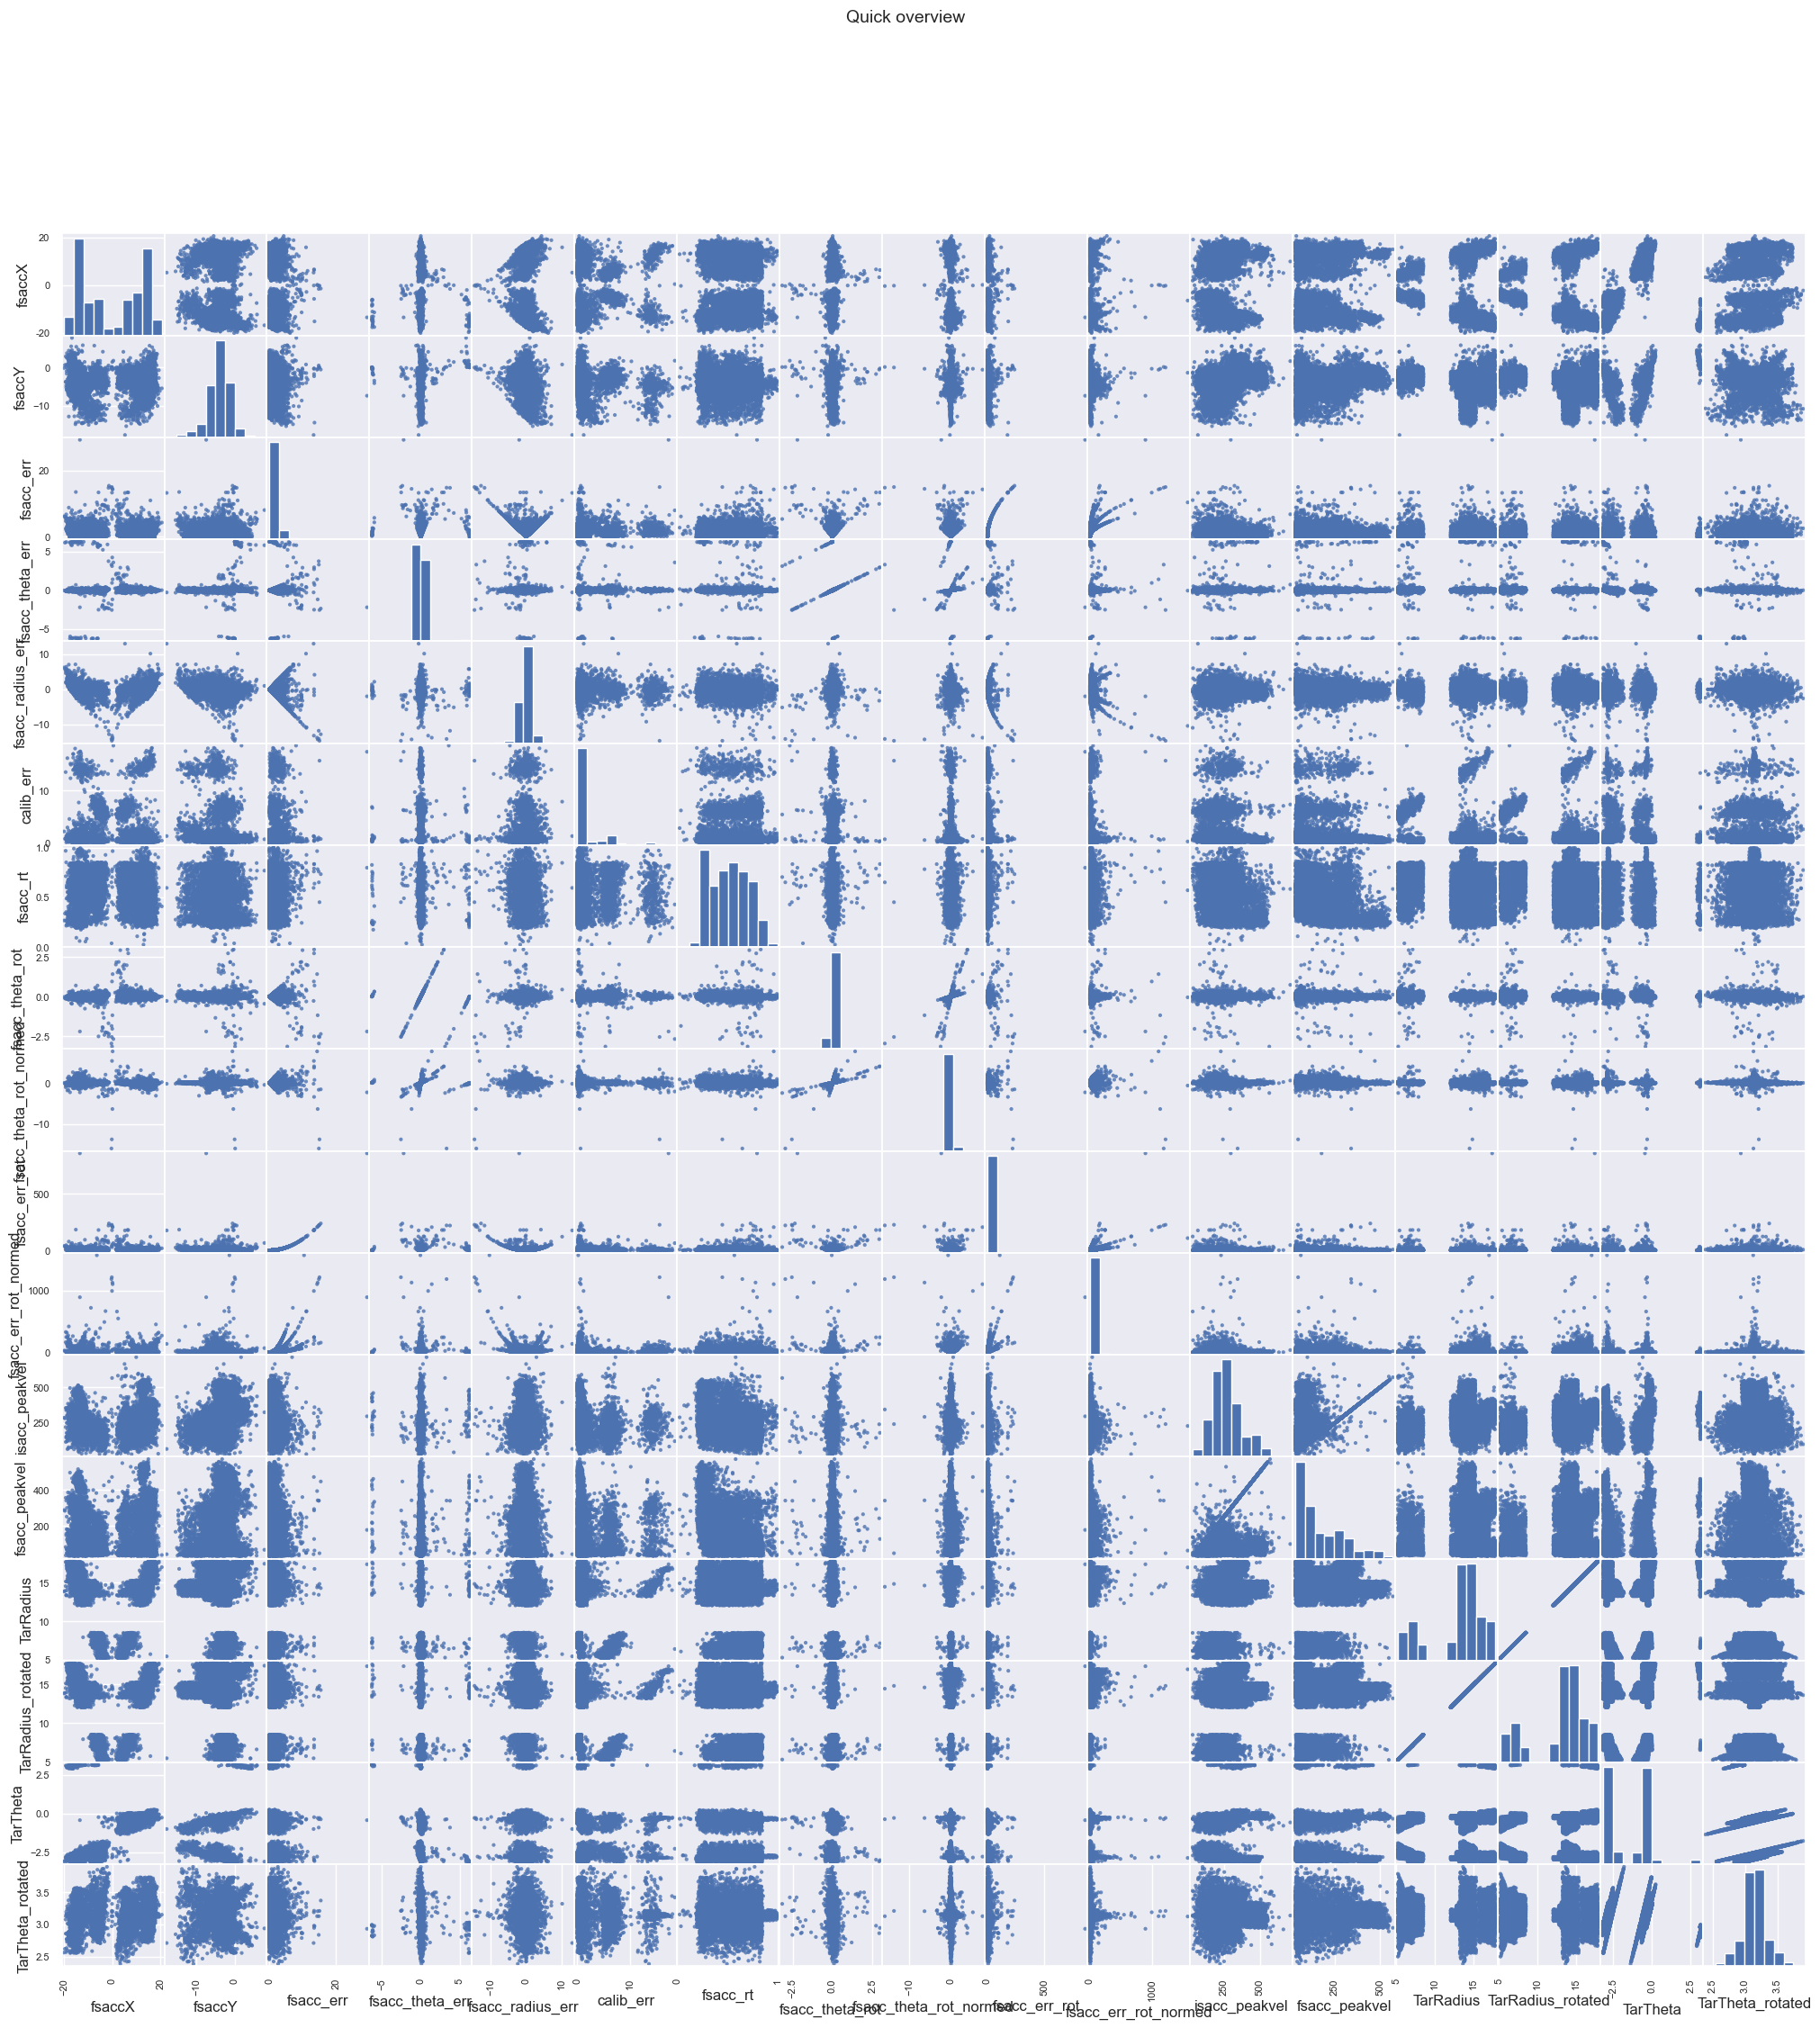

In [10]:
quick_visualization(df_filtered)

In [ ]:
distribution_plots(df_filtered)